<a href="https://colab.research.google.com/github/Sandhya-G/Aggression-Detection/blob/master/notebook/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hierarchical Attention Networks for Document Classification Zichao Yang paper
it has two levels of attention mechanisms applied at the word and  sentence level. Unlike other deep learning models it does not give equal importance to all the words in a document (more like calculating tf-idf values using neural network). In this paper they capture the importance of words first at sentence level and then at document level. The output from bi directionl GRU which captures contextual information is fed into a shallow neural network with tanh activation function which is then multiplied by trainable **context vector** and normalized to an importance weight per word by softmax function.
The sum of these importance weights concatenated with the previously calculated  GRU output is called sentence vector.The same procedure is repeated for sentence vector the resulting output is a document vector  which can be used as features for document classification. In our case document length is very small hence we  only calculate word attention.
![HAN ARC](https://www.researchgate.net/publication/329116136/figure/fig3/AS:695612525797380@1542858358849/Hierarchical-Attention-Network-and-its-incorporation-to-our-model.ppm)
![attention](https://humboldt-wi.github.io/blog/img/seminar/group5_HAN/han_word.png)


Some of their hyperparameter:
* embedding dimension : 200
* bi-GRU(hidden units): 50 
* Optimizer : SGD with momentum 0.9 and lr was found using grid search
* mini batch : 64 (documents of similar length were organized to be a batch)


In [0]:

train_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TRAIN%23")
test_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TEST%23")

In [2]:
import os
import time
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

from keras.layers import Dense, Input, Embedding, Dropout, Activation, GRU, Conv1D, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import initializers, regularizers, constraints, optimizers, layers

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import *
from keras.models import *
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *





Using TensorFlow backend.


In [0]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2048,stratify=train_df["class"])

## some config values 
embed_size = 100 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 120 # max number of words in a question to use

## fill up the missing values
train_X = train_df["tweet"].fillna("_na_").values
val_X = val_df["tweet"].fillna("_na_").values
test_X = test_df["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features,filters="")
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen,padding='post',truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen,padding='post',truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen,padding='post',truncating='post')

## Get the target values
train_y = train_df['class'].values
val_y = val_df['class'].values


In [7]:
len(tokenizer.word_index)

38489

In [0]:
def load_glove_index():
    EMBEDDING_FILE = '/content/glove.twitter.27B.100d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:100]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    return embeddings_index

glove_embedding_index = load_glove_index()

In [11]:
glove_embedding_index.get('hi').shape

(100,)

In [0]:
num_words = max_features

embedding_matrix = np.zeros((num_words, embed_size))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = glove_embedding_index.get(word)

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
    else:
        if word.islower():
                # try to get the embedding of word in titlecase if lowercase is not present
                embedding_vector = glove_embedding_index.get(word.capitalize())
                if embedding_vector is not None: 
                    embedding_matrix[i] = embedding_vector

In [0]:
#custom attention layer refer the second figure and keras documentation ‘Writing your own Keras layer'. 
class Attention(Layer):
    #initialise
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        #calculations
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim




In [0]:
#using only sentence vector for classification
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(GRU(50, return_sequences=True))(x)
x = Bidirectional(GRU(50,return_sequences=True))(x)
x = Attention(maxlen)(x)
x = Dense(256, activation="relu")(x)
# x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [31]:
 model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 120, 100)          3000000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 120, 100)          45300     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 120, 100)          45300     
_________________________________________________________________
attention_27 (Attention)     (None, 100)               220       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257 

In [32]:

history = model.fit(train_X, train_y, epochs=10, batch_size=512, validation_data=(val_X, val_y), verbose=1)

Train on 34587 samples, validate on 3843 samples
Epoch 1/10
34587/34587 [==============================] - 69s 2ms/step - loss: 0.3654 - accuracy: 0.8410 - val_loss: 0.2166 - val_accuracy: 0.9183
Epoch 2/10
34587/34587 [==============================] - 64s 2ms/step - loss: 0.2107 - accuracy: 0.9220 - val_loss: 0.1971 - val_accuracy: 0.9282
Epoch 3/10
34587/34587 [==============================] - 64s 2ms/step - loss: 0.1890 - accuracy: 0.9294 - val_loss: 0.1839 - val_accuracy: 0.9347
Epoch 4/10
34587/34587 [==============================] - 63s 2ms/step - loss: 0.1786 - accuracy: 0.9322 - val_loss: 0.1720 - val_accuracy: 0.9342
Epoch 5/10
34587/34587 [==============================] - 61s 2ms/step - loss: 0.1718 - accuracy: 0.9361 - val_loss: 0.1722 - val_accuracy: 0.9347
Epoch 6/10
34587/34587 [==============================] - 61s 2ms/step - loss: 0.1626 - accuracy: 0.9383 - val_loss: 0.1676 - val_accuracy: 0.9373
Epoch 7/10
34587/34587 [==============================] - 61s 2ms/ste

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# codes from machinelearningmastery.com
def print_hist(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

   
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


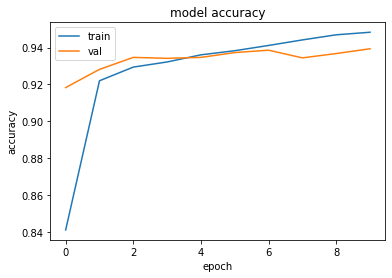

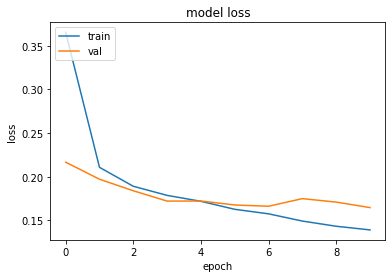

In [34]:
print_hist(history)

# CLR

In [0]:
pred_test = model.predict(test_X)

In [0]:
model.predict(tokenizer.t)